# Aula 3 - Redução de Dimensionalidade e Principal Component Analysis (PCA)

Prof. Dr. Ahirton Lopes

## Demo 5 - Reconhecimento Facial e PCA

Como exemplo de PCA sendo utilizado em conjunto com algoritmos de classificação , vamos dar uma olhada no problema de reconhecimento facial via SVM.

Usaremos o conjunto de dados Labeled Faces in the Wild, que consiste em vários milhares de fotos coletadas de várias figuras públicas.

Um buscador para o conjunto de dados está integrado ao Scikit-Learn:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Vamos plotar algumas dessas faces para ver com o que estamos trabalhando (veja a figura a seguir):

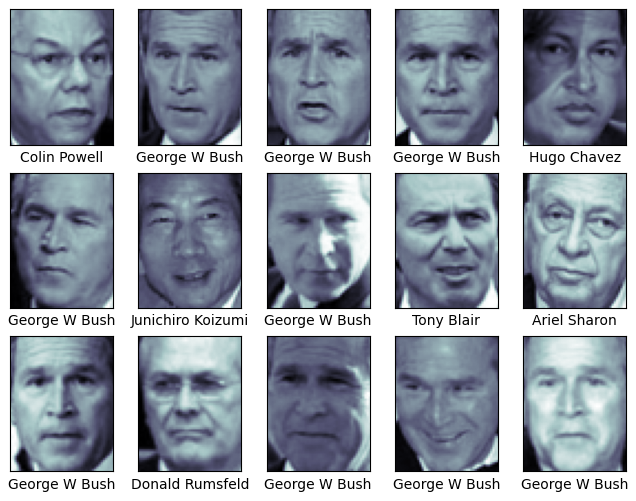

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagem contém 62 × 47, ou cerca de 3.000 pixels.
Poderíamos prosseguir simplesmente usando cada valor de pixel como um recurso, mas muitas vezes é mais eficaz usar algum tipo de pré-processador para extrair recursos mais significativos; aqui usaremos a análise de componentes principais (PCA) para extrair 150 componentes fundamentais para alimentar nosso classificador de máquina de vetores de suporte.
Podemos fazer isso de maneira mais direta, empacotando o pré-processador e o classificador em um único pipeline:

In [4]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Para testar a saída do nosso classificador dividiremos os dados em um conjunto de treinamento e um conjunto de teste:

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finalmente, podemos usar a validação cruzada de pesquisa em grade para explorar combinações de parâmetros. Aqui ajustaremos ``C`` (que controla a dureza da margem) e ``gamma`` (que controla o tamanho do kernel da função de base radial), e determinaremos o melhor modelo:

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 1min 35s
Wall time: 16.6 s
{'svc__C': 5, 'svc__gamma': 0.001}


Os valores ideais ficam no meio da nossa grade; se caíssem nas bordas, gostaríamos de expandir a grade para ter certeza de que encontramos o verdadeiro ótimo.

Agora, com este modelo de validação cruzada, podemos prever os rótulos dos dados de teste, que o modelo ainda não viu:

In [7]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Vamos dar uma olhada em algumas das imagens de teste junto com seus valores previstos (veja a figura a seguir):

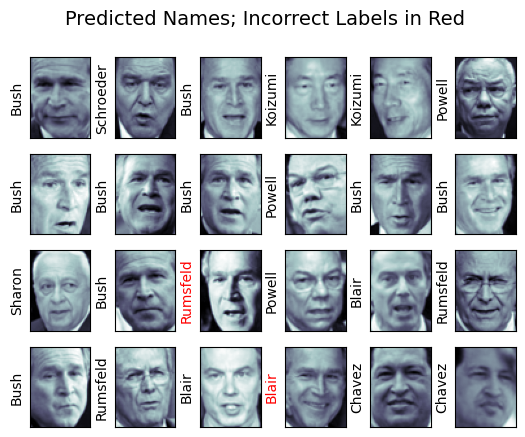

In [8]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Desta pequena amostra, nosso estimador ideal rotulou incorretamente duas faces.

Podemos ter uma noção melhor do desempenho do nosso estimador usando o relatório de classificação, que lista as estatísticas de recuperação rótulo por rótulo:

In [9]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



Poderíamos também exibir a matriz de confusão entre essas classes (veja a figura a seguir):

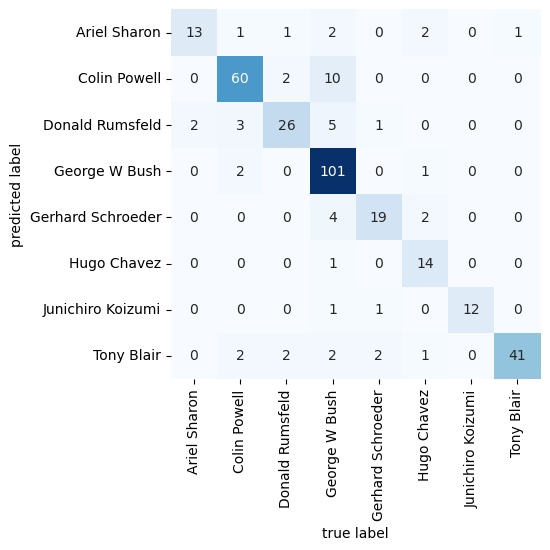

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Isso nos ajuda a ter uma noção de quais rótulos provavelmente serão confundidos pelo estimador.

Para uma tarefa de reconhecimento facial do mundo real, em que as fotos não vêm pré-cortadas em grades bonitas, a única diferença no esquema de classificação facial é a seleção de recursos: você precisaria usar um algoritmo mais sofisticado para encontrar os rostos, e extrair recursos que são independentes da pixelização.
Para esse tipo de aplicação, uma boa opção é utilizar o [OpenCV](http://opencv.org), que, entre outras coisas, inclui implementações pré-treinadas de ferramentas de extração de recursos de última geração para imagens em geral e rostos em particular.

## Resumo

Esta foi uma breve introdução intuitiva aos princípios por trás da utilização de PCA em problemas de Visão Computacional, aqui evidenciado pelo uso do SVM.

O SVM é um modelo de classificação poderoso por vários motivos:

- A sua dependência de relativamente poucos vectores de suporte significa que são compactos e ocupam muito pouca memória.
- Uma vez treinado o modelo, a fase de predição é muito rápida.
- Como são afetados apenas por pontos próximos à margem, eles funcionam bem com dados de alta dimensão — até mesmo dados com mais dimensões do que amostras, o que é um desafio para outros algoritmos.
- Sua integração com métodos kernel os torna muito versáteis, capazes de se adaptar a diversos tipos de dados.

No entanto, os SVMs também apresentam várias desvantagens:

- O escalonamento com o número de amostras $N$ é $\mathcal{O}[N^3]$ na pior das hipóteses, ou $\mathcal{O}[N^2]$ para implementações eficientes. Para um grande número de amostras de treinamento, esse custo computacional pode ser proibitivo.
- Os resultados dependem fortemente de uma escolha adequada do parâmetro de amolecimento `C`. Isso deve ser escolhido cuidadosamente por meio de validação cruzada, que pode ser cara à medida que os conjuntos de dados aumentam de tamanho.
- Os resultados não têm interpretação probabilística direta. Isto pode ser estimado através de uma validação cruzada interna (ver o parâmetro `probabilidade` de `SVC`), mas esta estimativa extra é dispendiosa.

Com essas características em mente, geralmente só recorro aos SVMs quando outros métodos mais simples, mais rápidos e com menos uso intensivo de ajuste se mostram insuficientes para minhas necessidades.
No entanto, se você tiver ciclos de CPU para se comprometer com o treinamento e a validação cruzada de um SVM em seus dados, o método pode levar a resultados excelentes.